# Analysis of the important books on Goodreads

In [27]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import numpy as np

books = pd.read_csv("books.csv")
ratings = pd.read_csv("ratings.csv")
book_tags = pd.read_csv("book_tags.csv")
tags = pd.read_csv("tags.csv")

Genre Map

In [28]:
# Merge to get tag names
book_tags_merged = pd.merge(book_tags, tags, on='tag_id', how='left')

# Define a list of non-genre tags to exclude
non_genres = [
    'to-read', 'currently-reading', 'favorites', 'owned', 'ebooks', 
    'audiobook', 're-read', 'audio', 'library', 'ebook'
]

# Filter out non-genre tags
book_tags_filtered = book_tags_merged[~book_tags_merged['tag_name'].isin(non_genres)]

# Select the most common genre tag for each book
top_tags = book_tags_filtered.sort_values('count', ascending=False).groupby('goodreads_book_id').first().reset_index()

# Map book_id to genre
book_genres = top_tags[['goodreads_book_id', 'tag_name']]
genre_map = dict(zip(book_genres['goodreads_book_id'], book_genres['tag_name']))

# Example: print the genre of book ID 1
print("Book ID 1 genre:", genre_map.get(1, "Unknown"))

Book ID 1 genre: fantasy


Book Network

In [ ]:
# Keep top N books by number of ratings
top_books = books.nlargest(1000, 'ratings_count')['book_id'].tolist()  # top 5k books

# Keep only ratings for top books
ratings_filtered = ratings[ratings['book_id'].isin(top_books)]

# Build user-book matrix
# Map user_id and book_id to indices
user_idx = {uid: i for i, uid in enumerate(ratings_filtered['user_id'].unique())}
book_idx = {bid: i for i, bid in enumerate(top_books)}

rows = ratings_filtered['user_id'].map(user_idx)
cols = ratings_filtered['book_id'].map(book_idx)
data = np.ones(len(ratings_filtered))

user_book_matrix = coo_matrix((data, (rows, cols)), shape=(len(user_idx), len(book_idx)))

# Compute co-readership 
co_matrix = user_book_matrix.T.dot(user_book_matrix).tocoo()  
# Remove self-loops
mask = co_matrix.row != co_matrix.col
rows, cols, data = co_matrix.row[mask], co_matrix.col[mask], co_matrix.data[mask]

# Build networkx graph
G = nx.Graph()
for r, c, w in zip(rows, cols, data):
    # Only keep edges with >= 2 co-readers
    if w >= 2:
        G.add_edge(top_books[r], top_books[c], weight=w)

print("Graph created with", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

# Map book_id to title/author 
id_to_title = dict(zip(books['book_id'], books['title']))

Graph created with 1000 nodes and 495862 edges


Centrality measures calculations

In [ ]:
# Degree Centrality (Popularity) 
deg_centrality = nx.degree_centrality(G)
top_deg = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

# Betweenness Centrality (Bridges) 
bet_centrality = nx.betweenness_centrality(G, k=50, seed=42)
top_btw = sorted(btw_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

# PageRank (Global Influence) 
pr_centrality = nx.pagerank(G, alpha=0.85)
top_pr = sorted(pr.items(), key=lambda x: x[1], reverse=True)[:10]

# Map book_id back to titles
book_titles = dict(zip(books['book_id'], books['title']))

def map_titles(top_list):
    return [(book_titles.get(book_id, "Unknown"), score) for book_id, score in top_list]

top_deg_titles = map_titles(top_deg)
top_btw_titles = map_titles(top_btw)
top_pr_titles = map_titles(top_pr)


# Display top 3 books for each measure 
print("Top 3 by Degree Centrality (Popularity):", top_deg_titles[:3])
print("Top 3 by Betweenness Centrality (Bridges):", top_btw_titles[:3])
print("Top 3 by PageRank (Global Influence):", top_pr_titles[:3])

Top 3 by Degree Centrality (Popularity): [('The Hunger Games (The Hunger Games, #1)', 1.0), ('Fallen (Fallen, #1)', 1.0), ('Chicka Chicka Boom Boom', 1.0)]
Top 3 by Betweenness Centrality (Bridges): [('The Hunger Games (The Hunger Games, #1)', 8.030883484015097e-06), ('Fallen (Fallen, #1)', 8.030883484015097e-06), ('Chicka Chicka Boom Boom', 8.030883484015097e-06)]
Top 3 by PageRank (Global Influence): [('The Hunger Games (The Hunger Games, #1)', 0.006230305159872811), ("Harry Potter and the Sorcerer's Stone (Harry Potter, #1)", 0.006021641838349388), ('To Kill a Mockingbird', 0.005430739432628907)]


Summary table of top books across centrality measures

In [68]:
# Identify top 3 books for each centrality measure
top_deg = sorted(deg_centrality, key=deg_centrality.get, reverse=True)[:3]
top_bet = sorted(bet_centrality, key=bet_centrality.get, reverse=True)[:3]
top_pr  = sorted(pr_centrality, key=pr_centrality.get, reverse=True)[:3]

# Combine all unique top books
all_top_books = list(set(top_deg + top_bet + top_pr))

# Prepare a DataFrame for all top books
top_books_data = []
for book_id in all_top_books:
    top_books_data.append({
        'Title': book_titles.get(book_id, 'Unknown'),
        'Degree Centrality': round(deg_centrality.get(book_id, 0), 4),
        'Betweenness Centrality': round(bet_centrality.get(book_id, 0), 8),
        'PageRank': round(pr_centrality.get(book_id, 0), 6)
    })

top_books_df = pd.DataFrame(top_books_data)

# Optional: Sort by Degree Centrality by default
top_books_df = top_books_df.sort_values('Degree Centrality', ascending=False).reset_index(drop=True)

# Display table
top_books_df


,Title,Degree Centrality,Betweenness Centrality,PageRank
0,"Fallen (Fallen, #1)",1.0,0.000008,0.000813
1,"The Hunger Games (The Hunger Games, #1)",1.0,0.000008,0.006230
2,Harry Potter and the Sorcerer's Stone (Harry P...,1.0,0.000008,0.006022
3,To Kill a Mockingbird,1.0,0.000008,0.005431
4,Chicka Chicka Boom Boom,1.0,0.000008,0.000435


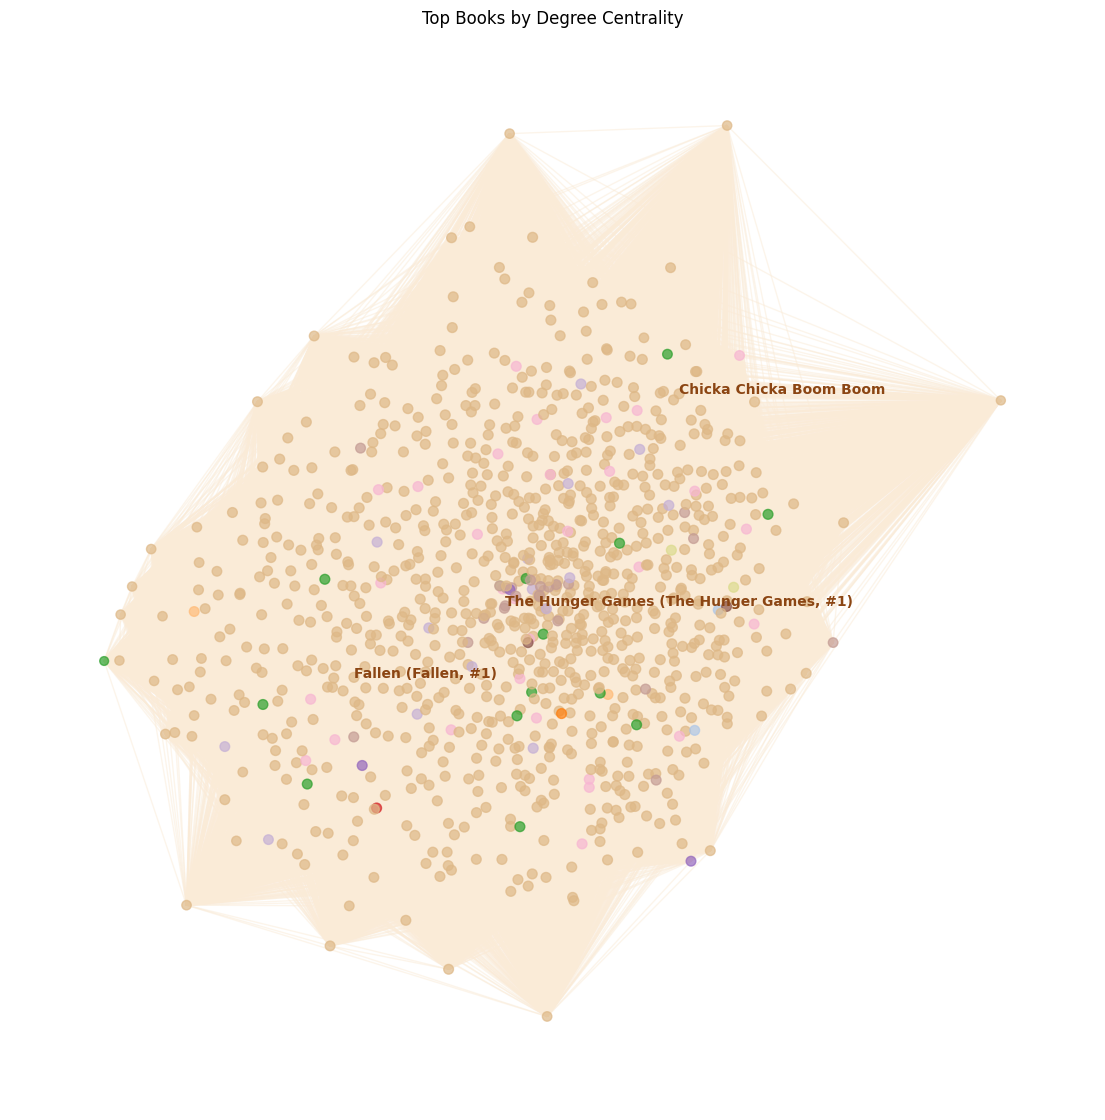

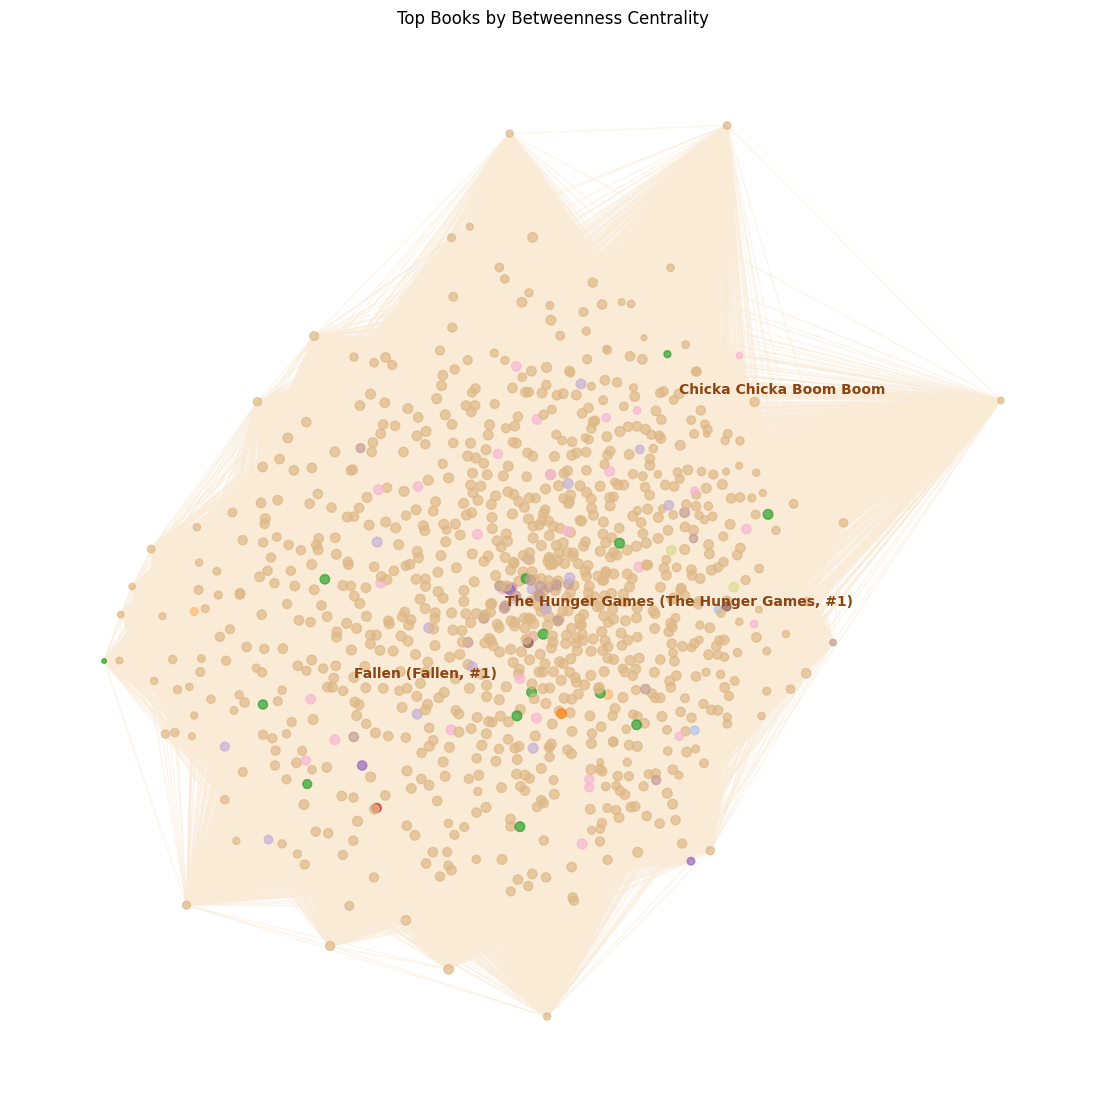

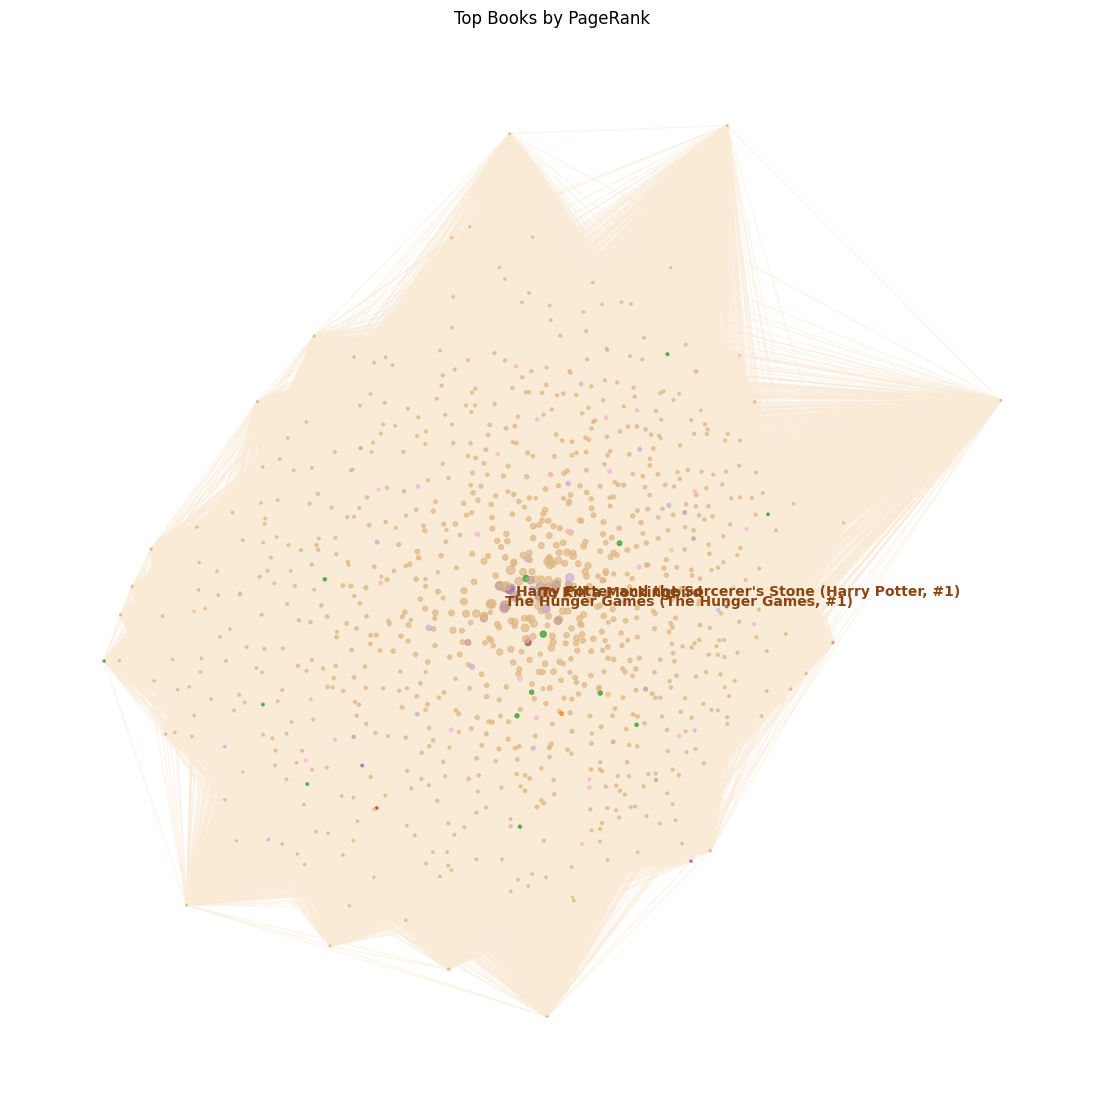

In [69]:
import matplotlib.pyplot as plt
import networkx as nx
# Optional for automatic label adjustment
try:
    from adjustText import adjust_text
    ADJUST_TEXT_AVAILABLE = True
except ImportError:
    ADJUST_TEXT_AVAILABLE = False

def draw_topk(G, centrality_dict, k=3, title="Network Graph", max_node_size=50, genre_map=None, book_titles=None):
    # Plot top-k nodes of a NetworkX graph with node sizes based on centrality.

    # Color map
    unique_genres = list(set(genre_map.values())) if genre_map else []
    palette = plt.cm.tab20.colors
    genre_color_map = {genre: palette[i % len(palette)] for i, genre in enumerate(unique_genres)}

    # Node sizes
    node_sizes = [centrality_dict.get(n, 0) / max(centrality_dict.values()) * max_node_size for n in G.nodes()]

    # Node colors
    node_colors = [genre_color_map.get(genre_map.get(n, 'Unknown'), 'burlywood') for n in G.nodes()] if genre_map else 'tan'

    # Layout: increase k to spread nodes further apart
    pos = nx.spring_layout(G, seed=42, k=0.25)

    plt.figure(figsize=(14,14))
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.7)
    nx.draw_networkx_edges(G, pos, edge_color='antiquewhite', alpha=0.5)

    # Label only top-k nodes by centrality
    top_nodes = sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:k]
    labels = {n: book_titles.get(n, '') for n, _ in top_nodes}
    
    texts = []
    for n, label in labels.items():
        x, y = pos[n]
        texts.append(plt.text(x, y, label, fontsize=10, fontweight='bold', color='saddlebrown'))

    # Automatically adjust labels if adjustText is available
    if ADJUST_TEXT_AVAILABLE:
        adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle='-', color='gray'))

    plt.title(title)
    plt.axis('off')
    plt.show()

draw_topk(G, deg_centrality, k=3, title="Top Books by Degree Centrality",
          genre_map=genre_map, book_titles=book_titles)

draw_topk(G, bet_centrality, k=3, title="Top Books by Betweenness Centrality",
          genre_map=genre_map, book_titles=book_titles)

draw_topk(G, pr_centrality, k=3, title="Top Books by PageRank",
          genre_map=genre_map, book_titles=book_titles)
